# Polymers Classifier

EM 538
Instructor:  
Student: Mike Keating


## Introduction and Background



## EDA, Cleaning, Preprocessing

Data was queried by polymer symbol (PP, PMMA, etc) and saved to separate csv files. Due to the nature of the search, there are likely blends and special materials included in each dataset, and we will want to pair down to a reasonable number of polymer classes


In [146]:

import os
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
# Combine all of the .csv files into one df
df = pd.DataFrame()
for file in os.listdir("data"):
    if file.endswith(".csv"):
        df_tmp = pd.read_csv(os.path.join("data", file))
        df = pd.concat([df, df_tmp], ignore_index=True)

# Discard completely empty columns
df = df.dropna(axis=1, how='all')   
# Drop polymer code column
df = df.drop("Polymer_Code", axis=1, errors='ignore')
# Clean up column names
df.columns = df.columns.str.strip().str.replace(" ", "_").str.replace("-", "_").str.replace("(", "").str.replace(")", "")
# Convert all column names to lowercase
df.columns = df.columns.str.lower()
# Remove degree symbol from column names
df.columns = df.columns.str.replace("°", "").str.replace("^" , "").str.replace("/", "")
# Get rid of units in column names
df.columns = df.columns.str.replace("_gcm3", "").str.replace("_mpa", "").str.replace("_c", "").str.replace("generic_polymer_symbol", "polymer_class")

# Drop hardness columns since the scales vary 
df = df.drop(["shore_a_hardness", "shore_d_hardness"], axis=1, errors='ignore')

# drop product_name, grade, generic_polymer_type
df = df.drop(["product_name", "grade", "generic_polymer_type"], axis=1, errors='ignore')
df.describe()

,density,tensile_strength_at_yield,melting_temperature,flexural_modulus,flexural_strength,tensile_modulus,tensile_strength_at_break,tensile_elongation_at_yield_%_strain,tensile_elongation_at_break_%_strain,izod_notched_impact_23c_kjm2,hardness_rockwell_r,hardness_shore_d
count,90013.000000,41474.000000,21905.000000,6.462500e+04,38131.000000,40056.000000,32333.000000,25546.000000,57706.000000,50658.000000,14019.000000,8424.000000
mean,1.219564,47.601638,208.005775,4.282031e+03,130.349497,5509.193415,78.071045,14.035342,121.637527,35.992922,101.600970,65.604582
std,4.424561,57.464644,52.036752,3.409535e+04,149.785827,5401.206573,107.106461,57.449070,1718.660233,133.546056,18.392496,13.317517
min,0.000920,0.082700,0.000000,9.650000e-01,0.000000,0.000000,0.000000,0.200000,0.000000,0.016000,7.000000,0.000000
25%,1.020000,26.000000,166.000000,1.590000e+03,68.300000,2160.000000,23.500000,3.900000,3.400000,5.196078,91.000000,60.000000
50%,1.180000,36.000000,220.000000,2.410000e+03,100.000000,3200.000000,60.000000,6.000000,16.000000,9.411765,105.000000,67.000000
75%,1.350000,60.000000,260.000000,5.240000e+03,180.000000,7700.000000,117.000000,10.000000,120.000000,20.000000,117.000000,75.000000
max,950.000000,9510.000000,387.000000,8.600000e+06,20700.000000,138000.000000,14000.000000,3700.000000,300000.000000,3921.568627,145.000000,122.000000


In [147]:

# Get an idea of the types of groups
df.groupby("polymer_class").size().sort_values(ascending=False)

polymer_class
PP, Unspecified    10070
Nylon 6             9530
PP Homopolymer      9416
Nylon 66            9011
PP Copolymer        5960
                   ...  
Nylon 66/610           1
PC+PSU                 1
PLA+HDPE               1
ASA+TPE                1
ULDPE+EVA              1
Length: 227, dtype: int64

In [148]:
# Discard polymer symbols that are blends, films, copolymers, alloys
# A blend has a "+" in the symbol
df = df[~df["polymer_class"].str.contains("\\+", na=False)]
# A film has "film" in the symbol
df = df[~df["polymer_class"].str.contains("Film", na=False)]
# An alloy has "alloy" in the symbol
df = df[~df["polymer_class"].str.contains("Alloy", na=False)]
# A copolymer has "copolymer" in the symbol
df = df[~df["polymer_class"].str.contains("Copolymer", na=False)]
# We are only trying to classify rigid polymers
df = df[~df["polymer_class"].str.contains("Flexible", na=False)]

# Discard any symbols that have less than 250 samples
df_counts = df.groupby("polymer_class").size()
df = df[df["polymer_class"].isin(df_counts[df_counts >= 250].index)]
df.groupby("polymer_class").size().sort_values(ascending=False)

polymer_class
PP, Unspecified             10070
Nylon 6                      9530
PP Homopolymer               9416
Nylon 66                     9011
PC                           5457
PVC, Unspecified             4949
ABS                          3153
HDPE                         2673
PPS                          2212
LLDPE                        1886
LDPE                         1797
PVC, Rigid                    986
PEEK                          847
EVA                           773
PET                           648
Nylon 12                      646
Acrylic (PMMA)                622
PEI                           563
Nylon, Unspecified            506
Nylon 66/6                    468
PTFE                          400
Nylon 612                     374
ASA                           354
Acetal (POM) Homopolymer      351
Nylon 610                     256
dtype: int64

For the purpose of this assigment, let's scale down our dataset to only the top handful of groups. We may downselect this further.

* Nylons (Nylon 6, Nylon 66)
* Polypropylene (PP Homopolymer)
* Polycarbonate (PC)
* Acrylonitrile butadiene styrene (ABS)
* High Density Polyethylenee (HDPE)
* Polyphenylene Sulfide (PPS)
* Low Density Polyethylene (LDPE)
* Polyetheretherketone (PEEK)



In [149]:
# Compile and assign some polymer symbols to groups
df["polymer_class"] = df["polymer_class"].replace({
    "Nylon 6": "Nylon",
    "Nylon 66": "Nylon",
    "PP Homopolymer": "PP",
    "PC": "PC",
    "ABS": "ABS",
    "HDPE": "HDPE",
    "PPS": "PPS",
    "LDPE": "LDPE",
    "PEEK": "PEEK",
    "PVC": "PVC, Rigid",
    "Acrylic (PMMA)": "Acrylic",
})

# Discard anything not in the above groups
df = df[df["polymer_class"].isin([
    "Nylon", "Polypropylene", "PC", "ABS", "HDPE",
    "PPS", "LDPE", "PEEK", "PP", "PVC", "PMMA"
])]

df.groupby("polymer_class").size().sort_values(ascending=False)

polymer_class
Nylon    18541
PP        9416
PC        5457
ABS       3153
HDPE      2673
PPS       2212
LDPE      1797
PEEK       847
dtype: int64

In [150]:
# Get an idea of missing values per group
df_missing = df.isnull().sum().sort_values(ascending=False)
df_missing = df_missing[df_missing > 0]
df_missing = df_missing.to_frame(name="Missing Values")
df_missing["Percentage"] = df_missing["Missing Values"] / len(df) * 100
df_missing = df_missing.sort_values(by="Percentage", ascending=False)

# Discard columns that have more than 55% missing values
threshold = len(df) * 0.45
df = df.dropna(thresh=threshold, axis=1)    

# Discard rows that have more than 55% missing values
threshold = len(df.columns) * 0.45
df = df.dropna(thresh=threshold, axis=0)

In [151]:
# Get a subset of each group to balance the dataset, need no missing values
df_balanced = pd.DataFrame()
for group in df["polymer_class"].unique():
    df_group = df[df["polymer_class"] == group]
    # Drop rows with any missing values
    df_group = df_group.dropna()
    # Get a random sample of up to 100 rows
    sample_size = min(500, len(df_group))
    if sample_size > 0:
        df_sample = df_group.sample(n=sample_size, random_state=42)
        df_balanced = pd.concat([df_balanced, df_sample], ignore_index=True)    
# Discard any groups with less than 100 samples


df_balanced = df_balanced[df_balanced["polymer_class"].isin(df_balanced.groupby("polymer_class").size()[df_balanced.groupby("polymer_class").size() >= 100].index)]

df_balanced.polymer_class.value_counts()



polymer_class
PP       500
Nylon    500
PC       500
ABS      348
PPS      342
PEEK     209
Name: count, dtype: int64

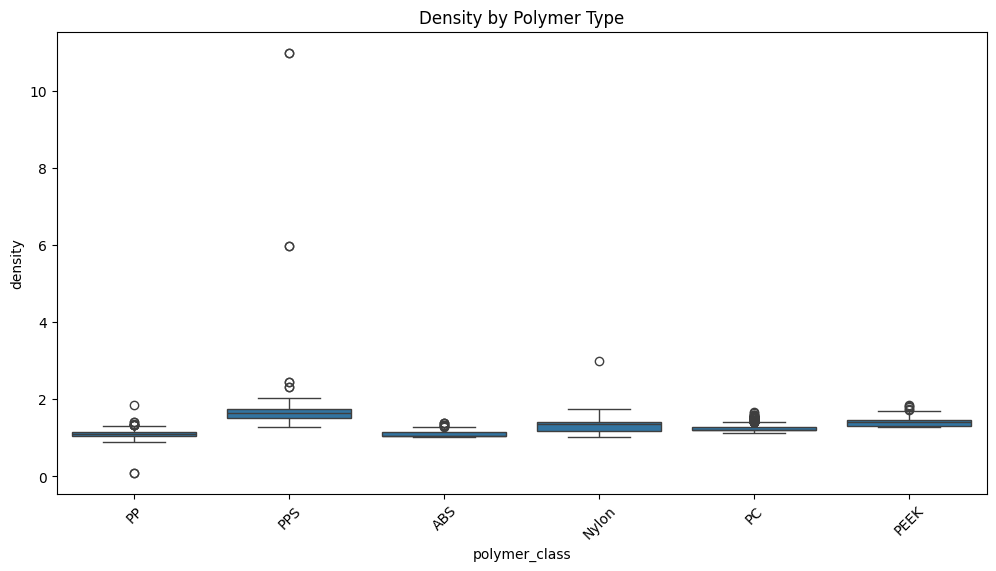

In [152]:
# EDA Boxplot
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
sns.boxplot(x="polymer_class", y="density", data=df_balanced)
plt.title("Density by Polymer Type")
plt.xticks(rotation=45)
plt.show()


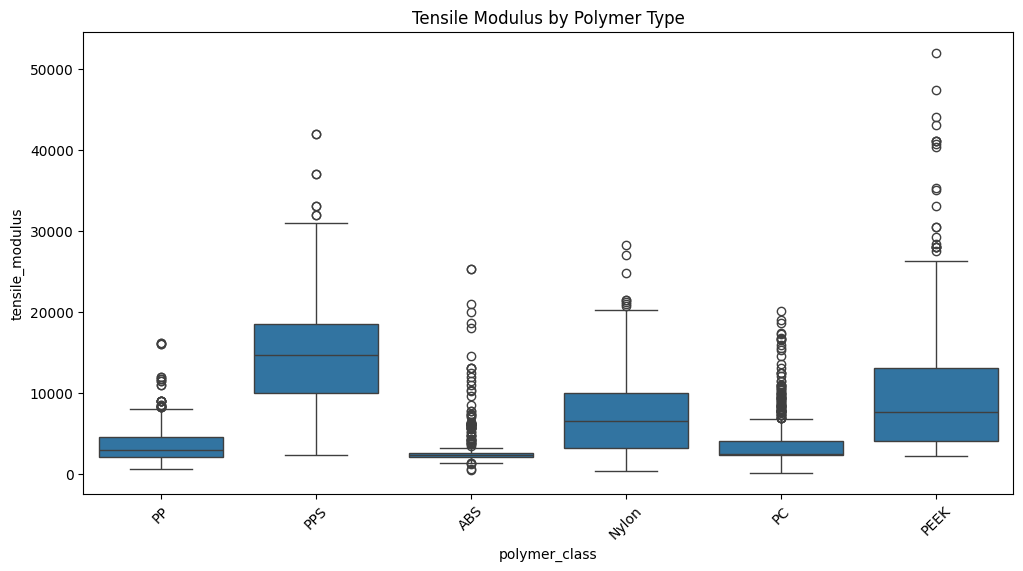

In [153]:
# Repeat for tensile modulus
plt.figure(figsize=(12, 6))
sns.boxplot(x="polymer_class", y="tensile_modulus", data=df_balanced)
plt.title("Tensile Modulus by Polymer Type")
plt.xticks(rotation=45)
plt.show()


We have some extreme outliers in the dataset for each group.

This is possibly due to an error with the datasource (unit issues, etc). For instance, a density above 10 g/cc is pretty unrealistic and certainly not typical of a polymer.

Let's handles this by removing any outliers not in the IQR by group and by column.

This may obscure some of the natural variability in our data (polymers can vary widely), but at least the core of each group will be preserved.

In [154]:
# # Handle outliers
# # Discard outliers in density

# def remove_iqr_outliers(group):
#     num_cols = group.select_dtypes(include='number').columns
#     for col in num_cols:
#         q1 = group[col].quantile(0.25)
#         q3 = group[col].quantile(0.75)
#         # inter quartile range
#         IQR = q3 - q1
#         lower = q1 - 1.5 * IQR
#         upper = q3 + 1.5 * IQR
#         group = group[(group[col] >= lower) & (group[col] <= upper)]
#     return group

# df_balanced = df_balanced.groupby('polymer_class', group_keys=False).apply(remove_iqr_outliers)

# import seaborn as sns
# import matplotlib.pyplot as plt
# plt.figure(figsize=(12, 6))
# sns.boxplot(x="polymer_class", y="density", data=filtered_df)
# plt.title("Density by Polymer Type")
# plt.xticks(rotation=45)
# plt.show()

# # Repeat for tensile modulus
# plt.figure(figsize=(12, 6))
# sns.boxplot(x="polymer_class", y="tensile_modulus", data=df_balanced)
# plt.title("Tensile Modulus by Polymer Type")
# plt.xticks(rotation=45)
# plt.show()


### Preprocessing for ML

In [ ]:
# Scale and encode the data
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
# Scale the numerical features
scaler = StandardScaler()
numerical_features = df_balanced.select_dtypes(include=["float64", "int64"]).columns.tolist()
df_balanced[numerical_features] = scaler.fit_transform(df_balanced[numerical_features])

# Encode the categorical features
label_encoder = LabelEncoder()
df_balanced["polymer_class"] = label_encoder.fit_transform(df_balanced["polymer_class"])

# Split the data into training and test sets
X = df_balanced.drop("polymer_class", axis=1)
y = df_balanced["polymer_class"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)   


## Modeling

### Logistic Regression

/Users/mikekeating/opt/anaconda3/envs/pyml/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/mikekeating/opt/anaconda3/envs/pyml/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/mikekeating/opt/anaconda3/envs/pyml/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/mikekeating/opt/anaconda3/envs/pyml/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/mikekeating/opt/anaconda3/envs/pyml/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_

Best parameters for Logistic Regression: {'logisticregression__C': 10, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'lbfgs'}
Classification Report for Logistic Regression:
               precision    recall  f1-score   support

         ABS       0.78      0.71      0.75        70
       Nylon       0.58      0.63      0.60       100
          PC       0.80      0.78      0.79       100
        PEEK       0.70      0.33      0.45        42
          PP       0.79      0.88      0.83       100
         PPS       0.71      0.81      0.75        68

    accuracy                           0.72       480
   macro avg       0.73      0.69      0.70       480
weighted avg       0.73      0.72      0.72       480



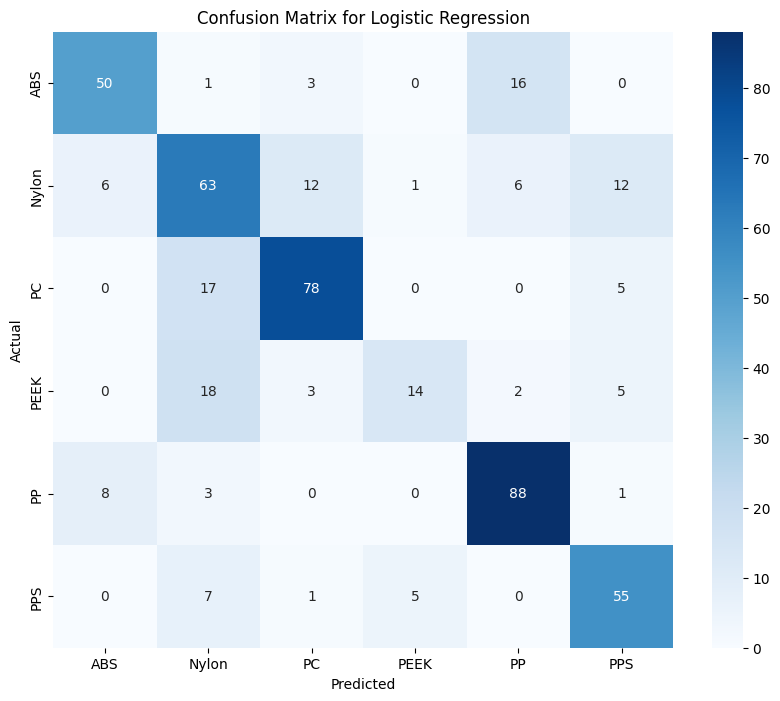

In [165]:
# Multi-class logistic regression
warnings.filterwarnings('ignore')
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

pipe_logreg = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))
pipe_logreg.fit(X_train, y_train)

param_grid_logreg = [
    {
        'logisticregression__solver': ['lbfgs'],
        'logisticregression__C': [0.01, 0.1, 1, 10],
        'logisticregression__penalty': ['l2'],
    },
    {
        'logisticregression__solver': ['liblinear'],
        'logisticregression__C': [0.01, 0.1, 1, 10],
        'logisticregression__penalty': ['l2'],
    },
    {
        'logisticregression__solver': ['saga'],
        'logisticregression__C': [0.01, 0.1, 1, 10],
        'logisticregression__penalty': ['l1', 'l2'],
    }
]
grid_search_logreg = GridSearchCV(pipe_logreg, param_grid_logreg, cv=5, scoring="accuracy", n_jobs=-1)

grid_search_logreg.fit(X_train, y_train)
y_pred_logreg = grid_search_logreg.predict(X_test)

print("Best parameters for Logistic Regression:", grid_search_logreg.best_params_)
print("Classification Report for Logistic Regression:\n", classification_report(y_test, y_pred_logreg, target_names=label_encoder.classes_))


# Visualize the results with seaborn
cm_logreg = confusion_matrix(y_test, y_pred_logreg)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_logreg, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix for Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### K-Nearest Neighbors

Best parameters: {'kneighborsclassifier__n_neighbors': 1}
Best cross-validation score: 0.8723358420593368
Test set score: 0.8833333333333333


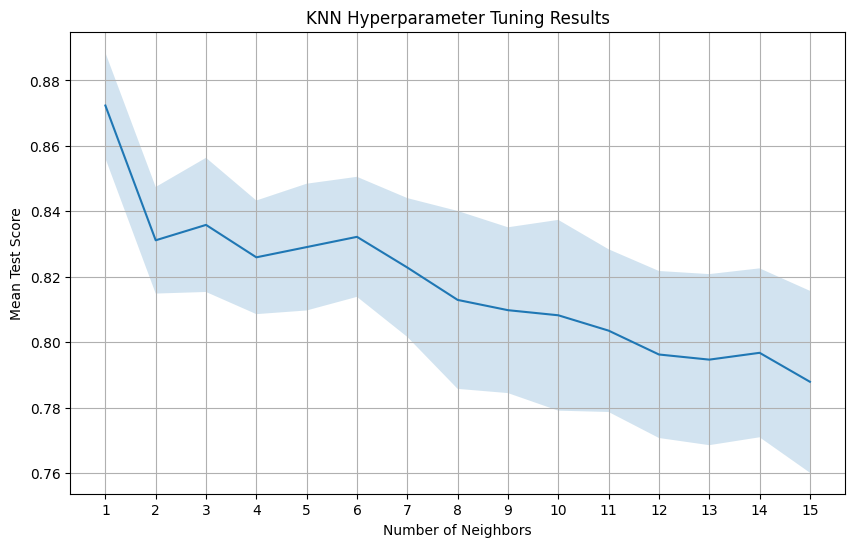

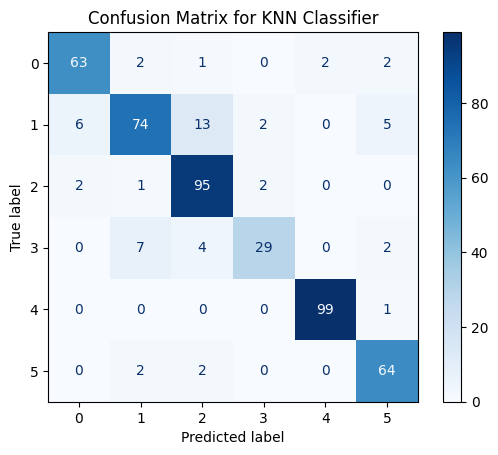

In [ ]:

from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier


param_range = range(1,16)
pipe_knn = make_pipeline(StandardScaler(), KNeighborsClassifier())
param_grid = [{"kneighborsclassifier__n_neighbors": param_range}]

gs = GridSearchCV(estimator=pipe_knn, param_grid=param_grid, scoring="accuracy", cv=10, n_jobs=-1)
gs = gs.fit(X_train, y_train)

print("Best parameters:", gs.best_params_)
print("Best cross-validation score:", gs.best_score_)
print("Test set score:", gs.score(X_test, y_test))

# Visualize the results with seaborn
results = pd.DataFrame(gs.cv_results_)
plt.figure(figsize=(10, 6))
sns.lineplot(x="param_kneighborsclassifier__n_neighbors", y="mean_test_score", data=results)
plt.fill_between(results["param_kneighborsclassifier__n_neighbors"],
                 results["mean_test_score"] - results["std_test_score"],
                 results["mean_test_score"] + results["std_test_score"], alpha=0.2)
plt.title("KNN Hyperparameter Tuning Results")
plt.xlabel("Number of Neighbors")
plt.ylabel("Mean Test Score")
plt.xticks(param_range)
plt.grid()
plt.show()

# Plot Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_pred = gs.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=gs.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=gs.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for KNN Classifier")
plt.show()


## Random Forest

Best parameters: {'randomforestclassifier__max_depth': None, 'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__min_samples_leaf': 1, 'randomforestclassifier__min_samples_split': 2, 'randomforestclassifier__n_estimators': 100}
Test classification report:
              precision    recall  f1-score   support

           0       0.96      0.91      0.93        70
           1       0.83      0.82      0.82       100
           2       0.88      0.95      0.91       100
           3       0.88      0.71      0.79        42
           4       0.97      0.98      0.98       100
           5       0.93      0.97      0.95        68

    accuracy                           0.91       480
   macro avg       0.91      0.89      0.90       480
weighted avg       0.91      0.91      0.91       480



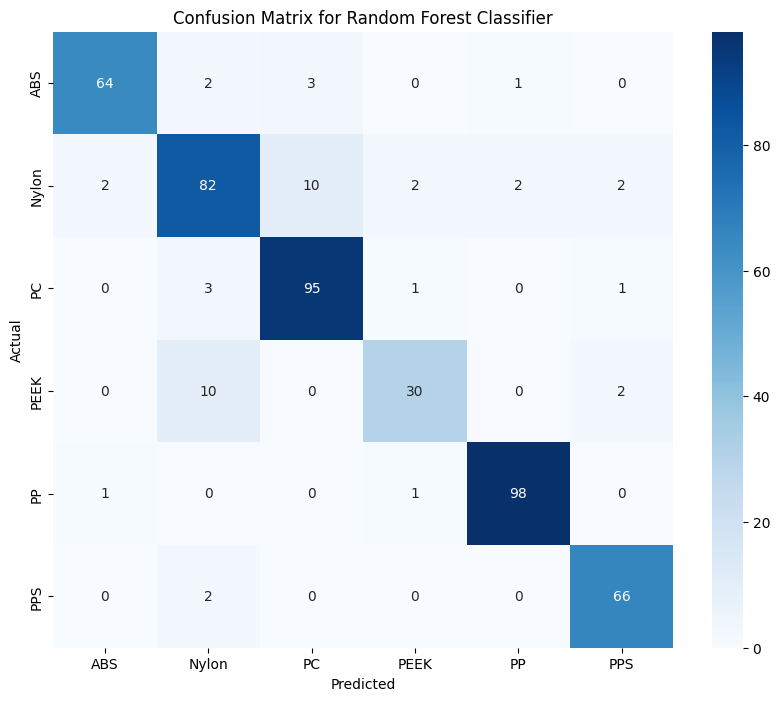

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Pipeline (scaling not strictly needed for Random Forest, but kept for consistency)
pipe_rf = make_pipeline(
    StandardScaler(),  # Can remove if all features are numeric and well-scaled already
    RandomForestClassifier(random_state=42)
)

# Grid of hyperparameters
param_grid_rf = {
    "randomforestclassifier__n_estimators": [100, 200],
    "randomforestclassifier__max_depth": [None, 10, 20],
    "randomforestclassifier__min_samples_split": [2, 5],
    "randomforestclassifier__min_samples_leaf": [1, 2],
    "randomforestclassifier__max_features": ['sqrt', 'log2', None]
}

# Grid search
grid_search_rf = GridSearchCV(
    pipe_rf,
    param_grid_rf,
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)

# Fit
grid_search_rf.fit(X_train, y_train)

# Predict with best model
y_pred_rf = grid_search_rf.predict(X_test)

# Results
print("Best parameters:", grid_search_rf.best_params_)
print("Test classification report:")
print(classification_report(y_test, y_pred_rf))

# Visualize the results with seaborn
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(10, 8)) 
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix for Random Forest Classifier")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [1]:

from xgboost import XGBClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

pipe_xgb = make_pipeline(
    StandardScaler(),  # Optional: XGBoost doesn't need this unless inputs are wildly scaled
    XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
)

param_grid_xgb = {
    'xgbclassifier__n_estimators': [100, 200],
    'xgbclassifier__max_depth': [3, 5, 7],
    'xgbclassifier__learning_rate': [0.01, 0.1, 0.3],
}

grid_search_xgb = GridSearchCV(pipe_xgb, param_grid_xgb, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_xgb.fit(X_train, y_train)

print("Best parameters:", grid_search_xgb.best_params_)
print(classification_report(y_test, grid_search_xgb.predict(X_test)))

XGBoostError: 
XGBoost Library (libxgboost.dylib) could not be loaded.
Likely causes:
  * OpenMP runtime is not installed
    - vcomp140.dll or libgomp-1.dll for Windows
    - libomp.dylib for Mac OSX
    - libgomp.so for Linux and other UNIX-like OSes
    Mac OSX users: Run `brew install libomp` to install OpenMP runtime.

  * You are running 32-bit Python on a 64-bit OS

Error message(s): ["dlopen(/Users/mikekeating/opt/anaconda3/envs/pyml/lib/python3.13/site-packages/xgboost/lib/libxgboost.dylib, 0x0006): Library not loaded: @rpath/libomp.dylib\n  Referenced from: <3438F411-CE75-3B9D-AC3F-79994953DB2D> /Users/mikekeating/opt/anaconda3/envs/pyml/lib/python3.13/site-packages/xgboost/lib/libxgboost.dylib\n  Reason: tried: '/usr/local/opt/libomp/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/usr/local/opt/libomp/lib/libomp.dylib' (no such file), '/usr/local/opt/libomp/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/usr/local/opt/libomp/lib/libomp.dylib' (no such file), '/Users/mikekeating/opt/anaconda3/envs/pyml/lib/python3.13/lib-dynload/../../libomp.dylib' (no such file), '/Users/mikekeating/opt/anaconda3/envs/pyml/bin/../lib/libomp.dylib' (no such file)"]
